# This script is created by Yue on 4/26/23.

Workflow:
1. Load original instant data of ux,uy,uz 
1. Filter by missing counts, flags.
1. Calculate air density.
1. Despike.
1. Calculate wind angle and qc flag.
1. Tilt rotation.
1. Detrend.
1. Density correction. (neglect)
1. Spectral correction. (neglect)
1. Quality control.

q,P measurements are very weird so I didn't perform de-spiking on them.\
qc=0: data is good; =1: data is bad.\
webb_corr=1: correct q,T,C; =2: correct q,C; =0: no correction.\
Only do high-pass filtering on u.

# Set up environment

In [2]:
# This jupyter notebook command inserts matplotlib graphics in to the workbook
%matplotlib inline

# import packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path
import pickle
import time
from matplotlib.pyplot import figure
import scipy.io as sio
from datetime import date, timedelta
from math import *
from scipy.stats import gmean
from scipy import ndimage
from scipy import stats
from scipy import signal
import seaborn as sns
from scipy.signal import butter,sosfiltfilt,filtfilt
from scipy import fftpack
import math

# Define parameters

In [3]:
# directories
IN_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/processed_data/"
OUT_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/processed_data_020124/"
# Neutral_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/neutral_data_20200925_20210423/"
# FIG_DIR = '/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/fig_neutral/'

# physical constants (or values that are assumed constant)
Rw  = 461.5     # ideal gas constant for water vapor, J/kg*K
Rd  = 287.05    # ideal gas constant for dry air, J/kg*K
Lv  = 1000*2257 # latent heat of vaporization (water), J/kg
Cp  = 1005      # approximate constant pressure specific heat of air, J/kg*K
k   = 0.4      # Von Karman constant
g   = 9.81      # acceleration of gravity, m/s^2

# global constants
sonum    =12                       # number of sonic
z  = np.array([1.2,2,3.5,6,9,12.5,16.5,23,30,40,50,60])  # height of sonic above ground, 
frequency=10                   # sampling rate, Hz
time_avg =3600                  # average time, s
rpat = time_avg*frequency           # number of lines for a loop
A1 = 1 # constants in Townsend's formulations for the normalized standard deviation of horizontal velocity
B1 = 2.5
min_wnd  = 120
max_wnd  = 240 

# Filter requirements.
T = time_avg         # Sample Period
l_cutoff = 2000      # cutoff wavelength, m
order = 10       # filter order
nyq = 0.5 * frequency  # Nyquist Frequency
n = int(T * frequency) # total number of samples

# variables
# day = date(2021,4,10)
list_all = np.arange(0,12)
ins_var=['u_ins','v_ins','w_ins','Tsonic_ins','q_ins','P_ins','diag_csat_ins']
# ins_var=['u_ins3d','v_ins3d','w_ins3d'] # 36000 instantaneous variables per hour
# hr_var = ['rot_ang_v'] # hourly averaged data
# neutral_var = ['neutral_case','u_avg_neutral','u_star_m2']
# output variables
out_tur = ['ux_dspk', 'uy_dspk', 'uz_dspk', 'T_dspk',
           'u_dspk_2rot_ldtr', 'v_dspk_2rot_ldtr', 'w_dspk_2rot_ldtr', 'T_dspk_ldtr', 
           'u_dspk_2rot_trend', 'v_dspk_2rot_trend', 'w_dspk_2rot_trend', 'T_dspk_trend',
           'u_dspk_2rot_filt', 'v_dspk_2rot_filt', 'w_dspk_2rot_filt', 'T_dspk_filt',
           'u_tur_ldtr', 'v_tur_ldtr', 'w_tur_ldtr', 'T_tur_ldtr',
           'u_tur_filt', 'v_tur_filt', 'w_tur_filt', 'T_tur_filt']
out_avg = ['P_avg', 'T_avg', 'q_avg', 'Rho_air', 
           'u_avg_ldtr', 'v_avg_ldtr', 'w_avg_ldtr', 'T_avg_ldtr', 
           'u_avg_filt', 'v_avg_filt', 'w_avg_filt', 'T_avg_filt']
out_std = ['u_std_ldtr', 'v_std_ldtr', 'w_std_ldtr', 'T_std_ldtr',
           'u_std_filt', 'v_std_filt', 'w_std_filt', 'T_std_filt']
out_flux = ['uw_ldtr', 'vw_ldtr', 'wT_ldtr', 'u_star_ldtr', 'H_ldtr', 
            'uw_filt', 'vw_filt', 'wT_filt', 'u_star_filt', 'H_filt']
out_other = ['ts_dspk_wind_ang', 'u_filt_size', 'L_H2_ldtr', 'stability_ldtr', 'L_H2_filt', 'stability_filt',
             'mask_neutral', 'mask_taylor', 'mask_magnitude', 'mask_qc', 'mask_all']
out_qf = ['qc_ux_nan', 'qc_uy_nan', 'qc_uz_nan', 'qc_T_nan', 'qc_q_nan', 'qc_P_nan',
          'qc_ux_dspk', 'qc_uy_dspk', 'qc_uz_dspk', 'qc_T_dspk','qc_wdir_dspk']
out_nspikes = ['u_nspikes', 'v_nspikes', 'w_nspikes', 'T_nspikes', 'qc_wdir_dspk']

# labels
list_bot = np.array([0,1,2,3,4]) # bottom five levels
list_sel_m2 = np.array([5,6,7,8,9,10]) # from level 6 to level 11
level = ['L1', 'L2', 'L3','L4', 'L5', 'L6','L7', 'L8', 'L9','L10', 'L11', 'L12']

# PLOTTING STUFF
## define useful fonts
plt.rc('text', usetex=True)
# plt.rc('font', family='sans-serif')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
font_size = 18
# ldg = np.array(['B2','B3','B4','A1','A2','A3'])
ldg = np.array(["12.5","16.5","23","30","40","50"])
color_list=sns.color_palette("tab10")

# DataFrame
# creating a list of column names
col_names = ['u_unrot','v_unrot','w_unrot','u_rot',
             'v_rot','w_rot','wspd','wdir']
col_names = ['u_nspikes','qc_u_spikes',
             'v_nspikes','qc_v_spikes','w_nspikes','qc_w_spikes',
             'T_nspikes','qc_T_spikes']

# controls
webb_corr = 2 # do webb-corr on q and C only

# Define functions

In [4]:
def date_list(sdate,edate):
    """method used for creating date list"""
    delta = edate - sdate       # as timedelta
    day = [sdate+timedelta(days=x) for x in range(delta.days+1)]
    return day

def rmnan(data,flag):  
    """ method used for checking & rm nan"""  
    data[flag >= 65] = np.nan ## ！！！！！ get rid of bad data (thershold is 65)! ! ! ! !
    nansum = np.sum(np.isnan(data))
    qc = 0
    if nansum >= time_avg*frequency/10:
        data[:] = np.nan
        qc = 1
    return data,qc
    # for icol in range(sonum):
    #     nansum = np.sum(np.isnan(data[:,icol]),0)
    #     # if there are more than 10% nan in an hour, discard all data at that level
    #     if nansum >= time_avg*frequency/10:
    #         data[:,icol] = np.nan
    # return data
def get_wind_ang(ux,uy,nl):
    """
    !!!arctan return values in radians!!!
    for 1 level only
    calculate mean wind angle on the xy-plane (!! must do before double rotation)
    The CSAT3 (the anemometer arms, tripods) is aligned northward and if u is positive, the wind is northerly. 
    If v is positive, the wind is westerly.
    u:north(+)->south(-), v:west(+)->east(-)
    """
    u_avg = np.nanmean(ux,axis=0) # size = 1
    v_avg = np.nanmean(uy,axis=0)
    rot_ang_v = degrees(np.arctan(v_avg/u_avg))
    # print('nl='+str(nl))
    # if nl==2:
    #     wind_ang = rot_ang_v*np.nan
    #     mask1 = np.logical_and(u_avg>=0, v_avg<=0)
    #     wind_ang[mask1] = -rot_ang_v[mask1] # northeast
    #     mask2 = np.logical_and(u_avg<=0, v_avg<=0)
    #     wind_ang[mask2] = 180-rot_ang_v[mask2] # southest
    #     mask3 = np.logical_and(u_avg<=0, v_avg>=0)
    #     wind_ang[mask3] = 180-rot_ang_v[mask3] # southwest
    #     mask4 = np.logical_and(u_avg>=0, v_avg>=0)
    #     wind_ang[mask4] = 360-rot_ang_v[mask4] # northwest         
    if nl==1:
        wind_ang = rot_ang_v
        if np.logical_and(u_avg>=0, v_avg<=0):
            wind_ang = -rot_ang_v # northeast
        if np.logical_and(u_avg<=0, v_avg<=0):
            wind_ang = 180-rot_ang_v # southest
        if np.logical_and(u_avg<=0, v_avg>=0):
            wind_ang = 180-rot_ang_v # southwest
        if np.logical_and(u_avg>=0, v_avg>=0):
            wind_ang = 360-rot_ang_v # northwest 
    return wind_ang

def wind_ang(ux,uy):
    """
    calculate mean wind angle on the xy-plane (!! must do before double rotation)
    The CSAT3 (the anemometer arms, tripods) is aligned northward and if u is positive, the wind is northerly. 
    If v is positive, the wind is westerly.
    u:north(+)->south(-), v:west(+)->east(-)
    """
    u_avg = np.nanmean(ux,axis=0) # size = 12
    v_avg = np.nanmean(uy,axis=0)
    rot_ang_v = np.arctan(v_avg/u_avg)
    rot_ang_v = rot_ang_v*360/2/math.pi
    mask1 = np.logical_and(u_avg>=0, v_avg<=0)
    rot_ang_v[mask1] = -rot_ang_v[mask1] # northeast
    mask2 = np.logical_and(u_avg<=0, v_avg<=0)
    rot_ang_v[mask2] = 180-rot_ang_v[mask2] # southest
    mask3 = np.logical_and(u_avg<=0, v_avg>=0)
    rot_ang_v[mask3] = 180-rot_ang_v[mask3] # southwest
    mask4 = np.logical_and(u_avg>=0, v_avg>=0)
    rot_ang_v[mask4] = 360-rot_ang_v[mask4] # northwest
    
    # quality control: wind angle>120 and < 240
    qc = np.zeros(12)
    msk = np.logical_and(rot_ang_v> min_wnd,rot_ang_v<max_wnd)
    qc[msk] = 1
    return rot_ang_v,qc

def double_rot(ux,uy,uz):
    """
    Double rotation method (Note yaw correction must perform before pitch correction)
    https://www.licor.com/env/support/EddyPro/topics/anemometer-tilt-correction.html#:~:
    text=Double%20rotation%20method,by%20the%20flux%20averaging%20length.
    # such that the hourly avg of v and w will be zero
    # only u,v,w will be rotated, other variables remain the same
    """
    u_avg = np.nanmean(ux,axis=0) # size = 12
    v_avg = np.nanmean(uy,axis=0)
    w_avg = np.nanmean(uz,axis=0)
    # 1) yaw rotation
    C1 = (u_avg**2 + v_avg**2) ** 0.5
    rot_mat_1 = u_avg/C1
    rot_mat_2 = v_avg/C1
    rot_mat_3 = -v_avg/C1
    rot_mat_4 = u_avg/C1
    u_rot = ux * rot_mat_1 + uy*rot_mat_2
    v_rot = ux * rot_mat_3 + uy*rot_mat_4
    u_ins_yawrot = u_rot
    v_ins_2rot = v_rot
    u_avg_yawrot = np.nanmean(u_ins_yawrot,axis=0)
    # v_avg_2rot = np.nanmean(v_ins_2rot,axis=0)

    # 2) pitch rotation
    C2 = (u_avg_yawrot**2 + w_avg**2) ** 0.5
    rot_mat_1 = u_avg_yawrot/C2
    rot_mat_2 = w_avg/C2
    rot_mat_3 =-w_avg/C2
    rot_mat_4 = u_avg_yawrot/C2
    u_rot = u_ins_yawrot * rot_mat_1 + uz*rot_mat_2
    w_rot = u_ins_yawrot * rot_mat_3 + uz*rot_mat_4
    u_ins_2rot = u_rot
    w_ins_2rot = w_rot
    # u_avg_2rot = np.nanmean(u_ins_2rot,axis=0)
    # w_avg_2rot = np.nanmean(w_ins_2rot,axis=0)
    
    return u_ins_2rot,v_ins_2rot,w_ins_2rot

def butter_lowpass_filter(filt_type, data, cutoff, fs, order):
    """
    The frequency response of the Butterworth filter is maximally flat 
    (i.e. has no ripples) in the passband and rolls off towards zero in the stopband, 
    hence its one of the most popular low pass filter.
    
    data shoule be turbulent component!
    """
    # replace nan by mean value
    data[np.argwhere(np.isnan(data))] = np.nanmean(data)
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    sos = butter(order, normal_cutoff, btype=filt_type, analog=False, output='sos',fs=fs)
    # Return the filtered output with the same shape as data
    # The function sosfiltfilt should be preferred over filtfilt 
    # for most filtering tasks, as second-order sections have fewer numerical problems.
    y = sosfiltfilt(sos, data) 
    return y

def get_u_star(u_tur_in,v_tur_in,w_tur_in):
    uw = np.nanmean(u_tur_in*w_tur_in,axis=0)
    vw = np.nanmean(v_tur_in*w_tur_in,axis=0)
    u_star = (np.maximum(0,(uw**2+vw**2)**0.5))**0.5
    return u_star
  

def dtrd(data):
    # Only return the turbulent component  
    # The result is equal to signal.detrend(data)+np.mean(data)
    ct = np.arange(len(data))
    a = -(len(data)*np.nansum(ct*data, axis=0) - np.nansum(ct, axis=0) * 
          np.nansum(data, axis=0)) / (np.nansum(ct**2, axis=0)-(np.nansum(ct, axis=0))**2)
    b = (np.nansum(data, axis=0) - a * np.nansum(ct, axis=0))/len(data)
    data_dtr = data + (a*ct+b) - np.nanmean(data)
    return data_dtr

def get_ist(data):
    """
    Return the non-stationarity index for every hourly time series 
    """
    data_5min = data.reshape([12,-1]) # split each hour into 12 chunks/every 5 min
    cvm = np.nanmean(np.nanvar(data_5min,axis=1)) # avg of the variance of each chunck
    ist_5min = abs(cvm-np.nanvar(data))/np.nanvar(data)
    return ist_5min

def z_score(intensity):
    """
    Z-score based approach for spike detection
    """
    mean_int = np.nanmean(intensity)
    std_int = np.nanstd(intensity)
    z_scores = (intensity-mean_int) / std_int
    return z_scores

def fixer(y,thres):
    """
    remove spikes and fix them with the mean of its immediate neighbors.
    Following Vickers and Mahrt (1997), 
    https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html
    """
    qc = 0
    it = 0
    y_original = y.copy()
    while it < 20: # iterate 20 times
        # print(f"the {it} iterations:")
        # print(f"the 0 windows")
        y_sub = y[0:12000] # moving window is 20 min
        y_fix = y_sub.copy()
        spikes = abs(np.array(z_score(y_sub))) > thres
        n_con_spk = 0 # counts of more than 4 consecutive spikes
        for i in np.where(spikes != 0)[0]:  # If we have an spike in position i
            if i == 12000 - 1:
                w2 = np.arange(i-3,i+1)
                w1 = w2
            elif i == 12000 - 2:
                w2 = np.arange(i-4,i)
                w1 = np.arange(i-3,i+1)
            elif i == 12000 - 3:
                w2 = np.arange(i-5,i-1)
                w1 = np.arange(i-3,i+1)
            else:
                w1 = np.arange(i-3,i+1)
                w2 = np.arange(i,i+4)
            # 4 consecutive outliers
            # are considered as a local trend and not counted as a spike. 
            if np.sum(spikes[w1])==4 or np.sum(spikes[w2])==4:
                # print(f"4 consecutive spikes.")
                n_con_spk += 1
            else:
                if i == 12000 - 1:
                    w = np.arange(12000-3,12000)
                else:
                    w = np.arange(i-1,i+2) # we select 3 points around our spike
                ww = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
                y_fix[i] = np.mean(y_sub[ww]) # and we average their values
        # nspikes = np.nansum(spikes) - n_con_spk
        y_new = y_fix
        # 2nd to 6th moving window
        for iw in np.arange(1,5):
            n_con_spk = 0
            # print(f"the {iw} windows")
            y_sub = y[iw*6000:iw*6000+12000]
            y_fix = y_sub.copy()
            spikes = abs(np.array(z_score(y_sub))) > thres
            for i in np.where(spikes != 0)[0]:  # If we have an spike in position i
                if i >= 6000:
                    if i == 12000 - 1:
                        w2 = np.arange(i-3,i+1)
                        w1 = w2
                    elif i == 12000 - 2:
                        w2 = np.arange(i-4,i)
                        w1 = np.arange(i-3,i+1)
                    elif i == 12000 - 3:
                        w2 = np.arange(i-5,i-1)
                        w1 = np.arange(i-3,i+1)
                    else:
                        w1 = np.arange(i-3,i+1)
                        w2 = np.arange(i,i+4)
                    # 4 consecutive outliers
                    # are considered as a local trend and not counted as a spike. 
                    if np.sum(spikes[w1])==4 or np.sum(spikes[w2])==4:         
                        # print(f"4 consecutive spikes.")
                        n_con_spk += 1
                    else:
                        if i == 12000 - 1:
                            w = np.arange(12000-3,12000)
                        else:
                            w = np.arange(i-1,i+2) # we select 3 points around our spike
                        ww = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
                        y_fix[i] = np.mean(y_sub[ww]) # and we average their values
            nspk = np.nansum(spikes[6000:12000]) - n_con_spk
            y_new = np.append(y_new,y_fix[6000:12000])
            # nspikes += nspk
        # print(f"{nspikes} spikes")
        # print("-----------")        
        # if it == 0:
        #     n_spikes = nspikes
        # else:
        n_spikes = np.sum((y_new-y_original)!=0)
        if n_spikes > 0.01*rpat: # accepted spikes is 1%
            qc = 1 # quality flag = 1, should be discarded from the results dataset.
            print("Too much number of spikes")
            break
        if n_spikes == 0:
            break
        y = y_new
        it += 1
    return y_new,qc,n_spikes

def abs_lim(y,lim):
    """
    After de-spiking,
    replace a value that is outside a user-defined plausible range 
    by the mean of neiboring variables. 
    """
    out_lier = abs(y)>lim
    # print(np.sum(out_lier))
    y_lim = y.copy()
    for i in np.where(out_lier!=0)[0]:
        w = np.arange(i-2,i+3) # select 5 points around 
        w2 = w[out_lier[w] == 0] # From such interval, we choose the ones which are not outliers
        y_lim[i] = np.mean(y[w2]) # and we average their values
    return y_lim

def CheckForLess(list1, val): 
    # traverse in the list
    for x in list1: 
        # compare with all the
        # values with value
        if val <= x:
            return False
    return True

# Load data and do the processing

In [5]:
# set up time period and initialize variables
Sdate = date(2020,9,25)
# Sdate = date(2021,3,2)
Edate = date(2021,4,23)
ds = date_list(Sdate,Edate)

In [5]:
%%time
neutral_case = []
for day in ds:
    strday = str(day.strftime("%Y%m%d"))
    fp_stats = IN_DIR + 'u_ins_' + strday +'.pkl'
    if (not os.path.isfile(fp_stats)):
        print(day.strftime("%Y%m%d")+' do not exist')
        continue
    print('start processing:'+ strday)
    # load data    
    for var in ins_var:
        a_file = open(IN_DIR + var + '_' + strday +'.pkl', "rb")
        globals()[var] = pickle.load(a_file)
        a_file.close()
    u_ins3d = u_ins.reshape(-1,rpat,sonum)
    v_ins3d = v_ins.reshape(-1,rpat,sonum)
    w_ins3d = w_ins.reshape(-1,rpat,sonum)
    T_ins3d = Tsonic_ins.reshape(-1,rpat,sonum)
    q_ins3d = q_ins.reshape(-1,rpat,sonum)
    P_ins3d = P_ins.reshape(-1,rpat,sonum)
    diag_ins3d = diag_csat_ins.reshape(-1,rpat,sonum)
  
    # data initialization---------------------------
    ## initialize qaulity flag to be 0
    qc_ux_nan = np.zeros((24,sonum)) 
    qc_uy_nan = np.zeros((24,sonum))
    qc_uz_nan = np.zeros((24,sonum))
    qc_T_nan = np.zeros((24,sonum))
    qc_q_nan = np.zeros((24,sonum))
    qc_P_nan = np.zeros((24,sonum))
    
    qc_ux_dspk = np.zeros((24,sonum)) 
    qc_uy_dspk = np.zeros((24,sonum))
    qc_uz_dspk = np.zeros((24,sonum))
    qc_T_dspk = np.zeros((24,sonum))
    
    ## number of spikes
    u_nspikes = np.zeros((24,sonum)) * np.nan
    v_nspikes = np.zeros((24,sonum)) * np.nan
    w_nspikes = np.zeros((24,sonum)) * np.nan
    T_nspikes = np.zeros((24,sonum)) * np.nan
    qc_wdir_dspk = np.zeros((24,sonum))
    
    ## hourly averaged wind angle
    ts_dspk_wind_ang = np.zeros((24,sonum)) * np.nan 
    ## high-pass filter size
    u_filt_size = np.zeros((24,sonum)) * np.nan
    
    ## mean variables
    P_avg = np.zeros((24,sonum)) * np.nan
    T_avg = np.zeros((24,sonum)) * np.nan
    q_avg = np.zeros((24,sonum)) * np.nan
    Rho_air = np.zeros((24,sonum)) * np.nan
    
    u_avg_ldtr = np.zeros((24,sonum)) * np.nan
    v_avg_ldtr = np.zeros((24,sonum)) * np.nan
    w_avg_ldtr = np.zeros((24,sonum)) * np.nan
    T_avg_ldtr = np.zeros((24,sonum)) * np.nan

    u_avg_filt = np.zeros((24,sonum)) * np.nan
    v_avg_filt = np.zeros((24,sonum)) * np.nan
    w_avg_filt = np.zeros((24,sonum)) * np.nan
    T_avg_filt = np.zeros((24,sonum)) * np.nan
    
    ## tur
    ux_dspk = np.zeros((24,rpat,sonum)) * np.nan
    uy_dspk = np.zeros((24,rpat,sonum)) * np.nan
    uz_dspk = np.zeros((24,rpat,sonum)) * np.nan
    T_dspk = np.zeros((24,rpat,sonum)) * np.nan
    
    u_dspk_2rot_ldtr = np.zeros((24,rpat,sonum)) * np.nan
    v_dspk_2rot_ldtr = np.zeros((24,rpat,sonum)) * np.nan
    w_dspk_2rot_ldtr = np.zeros((24,rpat,sonum)) * np.nan
    T_dspk_ldtr = np.zeros((24,rpat,sonum)) * np.nan
    
    u_dspk_2rot_trend = np.zeros((24,rpat,sonum)) * np.nan
    v_dspk_2rot_trend = np.zeros((24,rpat,sonum)) * np.nan
    w_dspk_2rot_trend = np.zeros((24,rpat,sonum)) * np.nan
    T_dspk_trend = np.zeros((24,rpat,sonum)) * np.nan
    
    u_dspk_2rot_filt = np.zeros((24,rpat,sonum)) * np.nan
    v_dspk_2rot_filt = np.zeros((24,rpat,sonum)) * np.nan
    w_dspk_2rot_filt = np.zeros((24,rpat,sonum)) * np.nan
    T_dspk_filt = np.zeros((24,rpat,sonum)) * np.nan
    
    u_tur_ldtr = np.zeros((24,rpat,sonum)) * np.nan
    v_tur_ldtr = np.zeros((24,rpat,sonum)) * np.nan
    w_tur_ldtr = np.zeros((24,rpat,sonum)) * np.nan
    T_tur_ldtr = np.zeros((24,rpat,sonum)) * np.nan 
    
    u_tur_filt = np.zeros((24,rpat,sonum)) * np.nan
    v_tur_filt = np.zeros((24,rpat,sonum)) * np.nan
    w_tur_filt = np.zeros((24,rpat,sonum)) * np.nan
    T_tur_filt = np.zeros((24,rpat,sonum)) * np.nan

    ## std
    u_std_ldtr = np.zeros((24,sonum)) * np.nan
    v_std_ldtr = np.zeros((24,sonum)) * np.nan
    w_std_ldtr = np.zeros((24,sonum)) * np.nan
    T_std_ldtr = np.zeros((24,sonum)) * np.nan
    
    u_std_filt = np.zeros((24,sonum)) * np.nan
    v_std_filt = np.zeros((24,sonum)) * np.nan
    w_std_filt = np.zeros((24,sonum)) * np.nan
    T_std_filt = np.zeros((24,sonum)) * np.nan
    
    ## fluxes
    uw_ldtr = np.zeros((24,sonum)) * np.nan
    vw_ldtr = np.zeros((24,sonum)) * np.nan
    wT_ldtr = np.zeros((24,sonum)) * np.nan
    u_star_ldtr = np.zeros((24,sonum)) * np.nan
    H_ldtr = np.zeros((24,sonum)) * np.nan
    
    uw_filt = np.zeros((24,sonum)) * np.nan
    vw_filt = np.zeros((24,sonum)) * np.nan
    wT_filt = np.zeros((24,sonum)) * np.nan
    u_star_filt = np.zeros((24,sonum)) * np.nan
    H_filt = np.zeros((24,sonum)) * np.nan
    
    ## other variables
    ### Obukhov length
    L_H2_ldtr = np.zeros((24,sonum)) * np.nan 
    stability_ldtr  = np.zeros((24,sonum)) * np.nan
    L_H2_filt = np.zeros((24,sonum)) * np.nan 
    stability_filt  = np.zeros((24,sonum)) * np.nan
    
    ## control flag (False)
    mask_neutral = np.zeros(24)
    mask_taylor = np.zeros(24)
    mask_magnitude = np.zeros(24)
    mask_qc = np.zeros(24)
    mask_all = np.zeros(24)
    
    ##-------------------------------------------------
    # loop over hours
    for ih in range(24): 
        ux_ts = u_ins3d[ih,:,:] #36000*12
        uy_ts = v_ins3d[ih,:,:]
        uz_ts = w_ins3d[ih,:,:]
        T_ts = T_ins3d[ih,:,:]
        q_ts = q_ins3d[ih,:,:]
        P_ts = P_ins3d[ih,:,:]
        diag = diag_ins3d[ih,:,:]
        
        # replace the whole chunk by nan if nan exceeds 10% in an hour
        # Get rid of bad data with diag_csat >= 65
        for il in range(12): # loop over levels
            ux_ts[:,il],qc_ux_nan[ih,il] = rmnan(ux_ts[:,il],diag[:,il])
            uy_ts[:,il],qc_uy_nan[ih,il] = rmnan(uy_ts[:,il],diag[:,il])
            uz_ts[:,il],qc_uz_nan[ih,il] = rmnan(uz_ts[:,il],diag[:,il])
            T_ts[:,il],qc_T_nan[ih,il] = rmnan(T_ts[:,il],diag[:,il])
            q_ts[:,il],qc_q_nan[ih,il] = rmnan(q_ts[:,il],diag[:,il])
            P_ts[:,il],qc_P_nan[ih,il] = rmnan(P_ts[:,il],diag[:,il])
        # print('rmnan done')
        # 0. calculate air density
        P_avg[ih,:] = np.nanmean(P_ts,axis=0) 
        T_avg[ih,:] = np.nanmean(T_ts,axis=0)
        q_avg[ih,:] = np.nanmean(q_ts,axis=0)
        Rho_air[ih,:] = P_avg[ih,:]/(287.04*T_avg[ih,:]) - 0.61*q_avg[ih,:]
        # fill in missing data
        Rho_air[ih,2] = 0.5*(Rho_air[ih,1] +Rho_air[ih,3])
        Rho_air[ih,4] = 0.5*(Rho_air[ih,3] +Rho_air[ih,5])   
        Rho_air[ih,6] = 0.5*(Rho_air[ih,5] +Rho_air[ih,7])
        Rho_air[ih,10] = 0.5*(Rho_air[ih,9] +Rho_air[ih,11]) 
        # print('Rho done')

        # 1. De-spiking
        for il in range(12): # loop over levels
            # if whole chunck is nan then skip de-spiking
            if np.any([qc_ux_nan[ih,il],qc_uy_nan[ih,il],qc_uz_nan[ih,il],qc_T_nan[ih,il]]):
                continue
            else:
                ux_dspk[ih,:,il],qc_ux_dspk[ih,il],u_nspikes[ih,il] = fixer(ux_ts[:,il],thres=3.5) # 36000*12, 24*12, 24*12
                uy_dspk[ih,:,il],qc_uy_dspk[ih,il],v_nspikes[ih,il] = fixer(uy_ts[:,il],thres=3.5)
                uz_dspk[ih,:,il],qc_uz_dspk[ih,il],w_nspikes[ih,il] = fixer(uz_ts[:,il],thres=5)
                T_dspk[ih,:,il],qc_T_dspk[ih,il],T_nspikes[ih,il] = fixer(T_ts[:,il],thres=3.5)
        # print('despike done')           
        # 2. Wind angle on the xy-plane 
        for il in range(12):
            ts_dspk_wind_ang[ih,il] = get_wind_ang(ux_dspk[ih,:,il],uy_dspk[ih,:,il],1)
            if np.logical_and(ts_dspk_wind_ang[ih,il]> min_wnd,ts_dspk_wind_ang[ih,il]<max_wnd):
                qc_wdir_dspk[ih,il] = 1
        # ts_dspk_wind_ang[ih,:],qc_wdir_dspk[ih,:] = wind_ang(ux_dspk[ih,:,:],uy_dspk[ih,:,:]) # 1*12, 1*12
        
        # 3. Double rotation
        u_dspk_2rot,v_dspk_2rot,w_dspk_2rot = double_rot(ux_dspk[ih,:,:],uy_dspk[ih,:,:],uz_dspk[ih,:,:])
        # print('2rot done')
        
        # Calculate mean variables
        u_avg_dspk_2rot = np.nanmean(u_dspk_2rot,axis=0) # 12*1
        v_avg_dspk_2rot = np.nanmean(v_dspk_2rot,axis=0)
        w_avg_dspk_2rot = np.nanmean(w_dspk_2rot,axis=0)
        T_avg_dspk = np.nanmean(T_dspk[ih,:,:],axis=0)
          
        # 4. Detrend
        for il in range(12): # loop over levels
            # if whole chunck is nan then skip detrend
            if np.any([qc_ux_nan[ih,il],qc_uy_nan[ih,il],qc_uz_nan[ih,il],qc_T_nan[ih,il]]):
                continue
            else:
                ## 4.1 Linear detrend
                u_dspk_2rot_ldtr[ih,:,il] = dtrd(u_dspk_2rot[:,il])
                v_dspk_2rot_ldtr[ih,:,il] = dtrd(v_dspk_2rot[:,il])
                w_dspk_2rot_ldtr[ih,:,il] = dtrd(w_dspk_2rot[:,il])
                T_dspk_ldtr[ih,:,il] = dtrd(T_dspk[ih,:,il])

                ## 4.2 high-pass filter detrend
                u_cutoff = u_avg_dspk_2rot[il]/l_cutoff     # desired cutoff frequency of the filter, Hz
                # print(cutoff)
                u_filt_size[ih,il] = int(1/u_cutoff) # seconds
                # print(filt_size)
                u_tur = u_dspk_2rot[:,il]-u_avg_dspk_2rot[il]
                u_dspk_2rot_trend[ih,:,il] = butter_lowpass_filter('low', u_tur, u_cutoff, frequency, order)
                u_dspk_2rot_filt[ih,:,il] = u_dspk_2rot[:,il]-u_dspk_2rot_trend[ih,:,il]
                # print('1')
                
                v_tur = v_dspk_2rot[:,il]-v_avg_dspk_2rot[il]
                v_dspk_2rot_trend[ih,:,il] = butter_lowpass_filter('low', v_tur, u_cutoff, frequency, order)
                v_dspk_2rot_filt[ih,:,il] = v_dspk_2rot[:,il]-v_dspk_2rot_trend[ih,:,il]
                # print('2')
                
                w_tur = w_dspk_2rot[:,il]-w_avg_dspk_2rot[il]
                w_dspk_2rot_trend[ih,:,il] = butter_lowpass_filter('low', w_tur, u_cutoff, frequency, order)
                w_dspk_2rot_filt[ih,:,il] = w_dspk_2rot[:,il]-w_dspk_2rot_trend[ih,:,il]
                # print('3')
                
                T_tur = T_dspk[ih,:,il]-T_avg_dspk[il]
                T_dspk_trend[ih,:,il] = butter_lowpass_filter('low', T_tur, u_cutoff, frequency, order)
                T_dspk_filt[ih,:,il] = T_dspk[ih,:,il]-T_dspk_trend[ih,:,il]
                breakpoint()
            
        # print('detrend done') 
        
        # 5. Calculate statistics (I will discard "_dspk_2rot" from now on)
        ## Calculate mean variables
        u_avg_ldtr[ih,:] = np.nanmean(u_dspk_2rot_ldtr[ih,:,:],axis=0) # 12*1
        v_avg_ldtr[ih,:] = np.nanmean(v_dspk_2rot_ldtr[ih,:,:],axis=0)
        w_avg_ldtr[ih,:] = np.nanmean(w_dspk_2rot_ldtr[ih,:,:],axis=0)
        T_avg_ldtr[ih,:] = np.nanmean(T_dspk_ldtr[ih,:,:],axis=0)
        
        u_avg_filt[ih,:] = np.nanmean(u_dspk_2rot_filt[ih,:,:],axis=0) # 12*1
        v_avg_filt[ih,:] = np.nanmean(v_dspk_2rot_filt[ih,:,:],axis=0)
        w_avg_filt[ih,:] = np.nanmean(w_dspk_2rot_filt[ih,:,:],axis=0)
        T_avg_filt[ih,:] = np.nanmean(T_dspk_filt[ih,:,:],axis=0)
        # print('1')
        
        ## calculate turbulent variables (36000*12)
        u_tur_ldtr[ih,:,:] = u_dspk_2rot_ldtr[ih,:,:] - u_avg_ldtr[ih,:]
        v_tur_ldtr[ih,:,:] = v_dspk_2rot_ldtr[ih,:,:] - v_avg_ldtr[ih,:] 
        w_tur_ldtr[ih,:,:] = w_dspk_2rot_ldtr[ih,:,:] - w_avg_ldtr[ih,:]
        T_tur_ldtr[ih,:,:] = T_dspk_ldtr[ih,:,:] - T_avg_ldtr[ih,:] 
        
        u_tur_filt[ih,:,:] = u_dspk_2rot_filt[ih,:,:] - u_avg_filt[ih,:]
        v_tur_filt[ih,:,:] = v_dspk_2rot_filt[ih,:,:] - v_avg_filt[ih,:]
        w_tur_filt[ih,:,:] = w_dspk_2rot_filt[ih,:,:] - w_avg_filt[ih,:]
        T_tur_filt[ih,:,:] = T_dspk_filt[ih,:,:] - T_avg_filt[ih,:]
        
        ## calculate standard deviations
        u_std_ldtr[ih,:] = np.nanstd(u_tur_ldtr[ih,:,:],axis=0)
        v_std_ldtr[ih,:] = np.nanstd(v_tur_ldtr[ih,:,:],axis=0)
        w_std_ldtr[ih,:] = np.nanstd(w_tur_ldtr[ih,:,:],axis=0)
        T_std_ldtr[ih,:] = np.nanstd(T_tur_ldtr[ih,:,:],axis=0)
        
        u_std_filt[ih,:] = np.nanstd(u_tur_filt[ih,:,:],axis=0)
        v_std_filt[ih,:] = np.nanstd(v_tur_filt[ih,:,:],axis=0)
        w_std_filt[ih,:] = np.nanstd(w_tur_filt[ih,:,:],axis=0)
        T_std_filt[ih,:] = np.nanstd(T_tur_filt[ih,:,:],axis=0)
        
        ## calcultate covariance and fluxes
        uw_ldtr[ih,:] = np.nanmean(u_tur_ldtr[ih,:,:]*w_tur_ldtr[ih,:,:],axis=0)
        vw_ldtr[ih,:] = np.nanmean(v_tur_ldtr[ih,:,:]*w_tur_ldtr[ih,:,:],axis=0)
        wT_ldtr[ih,:] = np.nanmean(w_tur_ldtr[ih,:,:]*T_tur_ldtr[ih,:,:],axis=0) # sensible heat flux
        H_ldtr[ih,:]  = Cp*Rho_air[ih,:]*wT_ldtr[ih,:]
        
        uw_filt[ih,:] = np.nanmean(u_tur_filt[ih,:,:]*w_tur_filt[ih,:,:],axis=0)
        vw_filt[ih,:] = np.nanmean(v_tur_filt[ih,:,:]*w_tur_filt[ih,:,:],axis=0)
        wT_filt[ih,:] = np.nanmean(w_tur_filt[ih,:,:]*T_tur_filt[ih,:,:],axis=0) # sensible heat flux
        H_filt[ih,:]  = Cp*Rho_air[ih,:]*wT_filt[ih,:]
        
        u_star_ldtr[ih,:] = np.maximum(0,(uw_ldtr[ih,:]**2+vw_ldtr[ih,:]**2)**0.25)
        u_star_filt[ih,:] = np.maximum(0,(uw_filt[ih,:]**2+vw_filt[ih,:]**2)**0.25)
        
        # 6. calculate other variables
        ## Obukhov length (m) without Evaporation term 
        ## results are very similar between _ldtr and _filt so only keep one
        L_H2_ldtr[ih,:] = -u_star_ldtr[ih,:]**3*T_avg_ldtr[ih,:]/(k*g*wT_ldtr[ih,:]) 
        stability_ldtr[ih,:] = z/L_H2_ldtr[ih,:]
        L_H2_filt[ih,:] = -u_star_filt[ih,:]**3*T_avg_filt[ih,:]/(k*g*wT_filt[ih,:]) 
        stability_filt[ih,:] = z/L_H2_filt[ih,:]
        
        # 7. Data screening
        ## neutral case |z/L|<0.1
        # mask_neutral[ih] = abs(stability[ih])<0.1
        mask_neutral_ldtr = CheckForLess(abs(stability_ldtr[ih,:]),0.1)
        mask_neutral_filt = CheckForLess(abs(stability_filt[ih,:]),0.1)
        mask_neutral[ih] = np.all([mask_neutral_ldtr,mask_neutral_filt])
        ## taylor_assumption_control sigma_u/U< 0.5
        ratio_u_ldtr = u_std_ldtr[ih,:]/u_avg_ldtr[ih,:]
        ratio_u_filt = u_std_filt[ih,:]/u_avg_filt[ih,:]
        msk1 = CheckForLess(ratio_u_ldtr[list_sel_m2],0.5)
        msk2 = CheckForLess(ratio_u_filt[list_sel_m2],0.5)
        mask_taylor[ih] = np.all([msk1,msk2])
        ## magnitude control u>0.05m/s,|H|>10 W/m2
        msk1 = CheckForLess(-u_star_ldtr[ih,list_sel_m2],-0.05)
        msk2 = CheckForLess(-u_star_filt[ih,list_sel_m2],-0.05)
        msk3 = CheckForLess(-abs(H_ldtr[ih,list_sel_m2]),-10)
        msk4 = CheckForLess(-abs(H_filt[ih,list_sel_m2]),-10)
        mask_magnitude[ih] = np.all([msk1,msk2,msk3,msk4])

        # qc should all be 0 so not any 1
        ## relax to six level due to data missing in some days
        crit1 = not np.any(qc_ux_nan[ih,list_sel_m2])
        crit2 = not np.any(qc_uy_nan[ih,list_sel_m2])
        crit3 = not np.any(qc_uz_nan[ih,list_sel_m2])
        crit5 = not np.any(qc_T_nan[ih,list_sel_m2])
        
        crit7 = not np.any(qc_ux_dspk[ih,list_sel_m2])
        crit8 = not np.any(qc_uy_dspk[ih,list_sel_m2])
        crit9 = not np.any(qc_uz_dspk[ih,list_sel_m2])
        crit10 = not np.any(qc_T_dspk[ih,list_sel_m2])
        
        crit11 = not np.any(qc_wdir_dspk[ih,list_sel_m2])
        
        mask_qc[ih] = np.all([crit1,crit2,crit3,crit5,crit7,crit8,crit9,crit10,crit11])
        mask_all[ih] = np.all([mask_qc[ih],mask_neutral[ih],mask_taylor[ih],mask_magnitude[ih]])
        
        if mask_all[ih] == 1:
            neutral_case.append([day,ih+1])
            print('-----hour:'+str(ih+1))
    
    print('start writing results')    
    # for var in out_tur+out_avg+out_std+out_flux+out_other+out_qf+out_nspikes:
    for var in out_tur+out_avg+out_std+out_flux+out_qf+['L_H2_ldtr', 'stability_ldtr', 'L_H2_filt', 'stability_filt',
             'mask_neutral', 'mask_taylor', 'mask_magnitude', 'mask_qc', 'mask_all']:
        a_file = open(OUT_DIR + var + '_' + strday +'.pkl', "wb")
        pickle.dump(eval(var), a_file)
        a_file.close()
    print('finish:'+ strday)
        
    

start processing:20210302
start writing results
finish:20210302
start processing:20210303
start writing results
finish:20210303
start processing:20210304
-----hour:17
start writing results
finish:20210304
start processing:20210305
start writing results
finish:20210305
start processing:20210306
-----hour:15
-----hour:16
-----hour:17
start writing results
finish:20210306
start processing:20210307
Too much number of spikes
start writing results
finish:20210307
start processing:20210308
start writing results
finish:20210308
start processing:20210309
start writing results
finish:20210309
start processing:20210310
start writing results
finish:20210310
start processing:20210311
start writing results
finish:20210311
start processing:20210312
start writing results
finish:20210312
start processing:20210313
start writing results
finish:20210313
start processing:20210314
start writing results
finish:20210314
start processing:20210315
start writing results
finish:20210315
start processing:20210316


# Save neutral_case

In [44]:
%%time
neutral_case = []
for day in ds:
    strday = str(day.strftime("%Y%m%d"))
    fp_stats = OUT_DIR + 'mask_all_' + strday +'.pkl'
    if (not os.path.isfile(fp_stats)):
        print(day.strftime("%Y%m%d")+' do not exist')
        continue
    # print('start processing:'+ strday)
    # load data    
    for var in ins_var:
        a_file = open(OUT_DIR + 'mask_all_' + strday +'.pkl', "rb")
        mask_all = pickle.load(a_file)
        a_file.close()
    for ih in range(24):
        if mask_all[ih] == 1:
            neutral_case.append([day,ih+1])
            # print('-----hour:'+str(ih+1))
print(len(neutral_case))

20201216 do not exist
59
CPU times: user 51.3 ms, sys: 52.4 ms, total: 104 ms
Wall time: 269 ms


In [45]:
a_file = open(OUT_DIR + 'neutral_case' +'.pkl', "wb")
pickle.dump(neutral_case, a_file)
a_file.close()

In [46]:
neutral_case

[[datetime.date(2020, 9, 25), 16],
 [datetime.date(2020, 9, 25), 17],
 [datetime.date(2020, 10, 10), 16],
 [datetime.date(2020, 10, 10), 21],
 [datetime.date(2020, 10, 12), 17],
 [datetime.date(2020, 10, 12), 18],
 [datetime.date(2020, 10, 13), 16],
 [datetime.date(2020, 10, 13), 18],
 [datetime.date(2020, 10, 13), 19],
 [datetime.date(2020, 10, 16), 17],
 [datetime.date(2020, 10, 18), 16],
 [datetime.date(2020, 10, 19), 9],
 [datetime.date(2020, 10, 21), 15],
 [datetime.date(2020, 10, 21), 16],
 [datetime.date(2020, 10, 21), 18],
 [datetime.date(2020, 10, 22), 4],
 [datetime.date(2020, 10, 24), 22],
 [datetime.date(2020, 10, 24), 23],
 [datetime.date(2020, 10, 24), 24],
 [datetime.date(2020, 10, 30), 16],
 [datetime.date(2020, 11, 8), 13],
 [datetime.date(2020, 11, 9), 16],
 [datetime.date(2020, 11, 14), 15],
 [datetime.date(2020, 11, 18), 15],
 [datetime.date(2020, 11, 19), 12],
 [datetime.date(2020, 11, 19), 16],
 [datetime.date(2020, 11, 19), 17],
 [datetime.date(2021, 1, 3), 13],


# Save one variable
e.g. u_std_filt

In [ ]:
# set up time period and initialize variables
# Sdate = date(2020,9,25)
Sdate = date(2020,9,25)
Edate = date(2021,4,23)
ds = date_list(Sdate,Edate)
for day in ds:
    strday = str(day.strftime("%Y%m%d"))
    fp_stats = IN_DIR + 'u_tur_filt_' + strday +'.pkl'
    if (not os.path.isfile(fp_stats)):
        print(day.strftime("%Y%m%d")+' do not exist')
        continue
    print('start processing:'+ strday)
    # load data 
    a_file = open(IN_DIR + 'u_tur_filt_' + strday +'.pkl', "rb")
    u_tur_filt = pickle.load(a_file)
    a_file.close()
    
    u_std_filt = np.zeros((24,sonum)) * np.nan
    for ih in range(24): 
        u_std_filt[ih,:] = np.nanstd(u_tur_filt[ih,:,:],axis=0)
    print('start writing results')
    a_file = open(IN_DIR + 'u_std_filt' + '_' + strday +'.pkl', "wb")
    pickle.dump(u_std_filt, a_file)
    a_file.close()

# recalculate mask

In [10]:
OUT_DIR

'/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/processed_data_020124/'

In [50]:
# set up time period and initialize variables
# Sdate = date(2020,9,25)
Sdate = date(2020,9,25)
Edate = date(2021,4,23)
ds = date_list(Sdate,Edate)
all_case = []
neutral_case_dspk = []
neutral_case_neu = []
neutral_case_wdir = []
neutral_case_tay = []
neutral_case_all = []
neutral_case_qc = []
for day in ds:
    strday = str(day.strftime("%Y%m%d"))
    fp_stats = OUT_DIR + 'ux_dspk_' + strday +'.pkl'
    if (not os.path.isfile(fp_stats)):
        print(day.strftime("%Y%m%d")+' do not exist')
        continue
    # print('start processing:'+ strday)
    # load data    
    # for var in ['ux_dspk', 'uy_dspk']:
    #     a_file = open(OUT_DIR + var + '_' + strday +'.pkl', "rb")
    #     globals()[var] = pickle.load(a_file)
    #     a_file.close()
    for var in ['qc_ux_nan', 'qc_uy_nan','qc_uz_nan','qc_T_nan',
                'qc_ux_dspk','qc_uy_dspk','qc_uz_dspk','qc_T_dspk','qc_wdir_dspk',
                'mask_neutral', 'mask_taylor','mask_magnitude']:
        a_file = open(OUT_DIR + var + '_' + strday +'.pkl', "rb")
        globals()[var] = pickle.load(a_file)
        a_file.close()
    # qc_wdir_dspk = np.zeros((24,sonum))
    # ts_dspk_wind_ang = np.zeros((24,sonum)) * np.nan 
    mask_qc = np.zeros(24)
    mask_all = np.zeros(24)
    mask_dspk = np.zeros(24)
    mask_neu = np.zeros(24)
    mask_wdir = np.zeros(24)
    mask_tay = np.zeros(24)
    for ih in range(24): 
        # for il in range(12):
        # #     ts_dspk_wind_ang[ih,il] = get_wind_ang(ux_dspk[ih,:,il],uy_dspk[ih,:,il],1)
        #     if np.logical_and(ts_dspk_wind_ang[ih,il]> min_wnd,ts_dspk_wind_ang[ih,il]<max_wnd):
        #         qc_wdir_dspk[ih,il] = 1
        
        # qc should all be 0 so not any 1
        ## relax to six level due to data missing in some days
        crit1 = not np.any(qc_ux_nan[ih,list_sel_m2])
        crit2 = not np.any(qc_uy_nan[ih,list_sel_m2])
        crit3 = not np.any(qc_uz_nan[ih,list_sel_m2])
        crit5 = not np.any(qc_T_nan[ih,list_sel_m2])
        
        crit7 = not np.any(qc_ux_dspk[ih,list_sel_m2])
        crit8 = not np.any(qc_uy_dspk[ih,list_sel_m2])
        crit9 = not np.any(qc_uz_dspk[ih,list_sel_m2])
        crit10 = not np.any(qc_T_dspk[ih,list_sel_m2])
        
        crit11 = not np.any(qc_wdir_dspk[ih,list_sel_m2])
        
        mask_qc[ih] = np.all([crit1,crit2,crit3,crit5,crit7,crit8,crit9,crit10,crit11])
        mask_all[ih] = np.all([mask_qc[ih],mask_neutral[ih],mask_taylor[ih],mask_magnitude[ih]])
        
        mask_dspk[ih] = np.all([crit1,crit2,crit3,crit5,crit7,crit8,crit9,crit10])
        mask_neu[ih] = np.all([mask_dspk[ih],mask_neutral[ih]])
        mask_wdir[ih] = np.all([mask_dspk[ih],mask_neutral[ih],crit11])
        mask_tay[ih] = np.all([mask_dspk[ih],mask_neutral[ih],crit11,mask_taylor[ih]])
        
        # mask_qc[ih] = np.all([crit1,crit2,crit3,crit5,crit7,crit8,crit9,crit10,crit11])
        # mask_2[ih] = np.all([mask_qc[ih],mask_neutral[ih],mask_taylor[ih]])
        # mask_all[ih] = np.all([mask_2[ih],mask_magnitude[ih]])
        if mask_dspk[ih] == 1:
            neutral_case_dspk.append([day,ih+1])
        if mask_neu[ih] == 1:
            neutral_case_neu.append([day,ih+1])
        if mask_wdir[ih] == 1:
            neutral_case_wdir.append([day,ih+1])
        if mask_tay[ih] == 1:
            neutral_case_tay.append([day,ih+1])
        if mask_all[ih] == 1:
            neutral_case_all.append([day,ih+1])
        if mask_qc[ih] == 1:
            neutral_case_qc.append([day,ih+1])
            # print([day,ih+1])
        all_case.append([day,ih+1])
    # print('start writing results')
    for var in ['mask_tay']:
        a_file = open(OUT_DIR + var + '_' + strday +'.pkl', "wb")
        pickle.dump(eval(var), a_file)
        a_file.close()
    print('finish:'+ strday)

# a_file = open(OUT_DIR + 'neutral_case_tay.pkl', "wb")
# pickle.dump(neutral_case_tay, a_file)
# a_file.close()

finish:20200925
finish:20200926
finish:20200927
finish:20200928
finish:20200929
finish:20200930
finish:20201001
finish:20201002
finish:20201003
finish:20201004
finish:20201005
finish:20201006
finish:20201007
finish:20201008
finish:20201009
finish:20201010
finish:20201011
finish:20201012
finish:20201013
finish:20201014
finish:20201015
finish:20201016
finish:20201017
finish:20201018
finish:20201019
finish:20201020
finish:20201021
finish:20201022
finish:20201023
finish:20201024
finish:20201025
finish:20201026
finish:20201027
finish:20201028
finish:20201029
finish:20201030
finish:20201031
finish:20201101
finish:20201102
finish:20201103
finish:20201104
finish:20201105
finish:20201106
finish:20201107
finish:20201108
finish:20201109
finish:20201110
finish:20201111
finish:20201112
finish:20201113
finish:20201114
finish:20201115
finish:20201116
finish:20201117
finish:20201118
finish:20201119
finish:20201120
finish:20201121
finish:20201122
finish:20201123
finish:20201124
finish:20201125
finish:2

In [43]:
len(all_case),len(neutral_case_dspk),len(neutral_case_neu),len(neutral_case_wdir),len(neutral_case_tay),len(neutral_case_all)

(5040, 4700, 148, 145, 139, 59)

In [20]:
diff2 = [item for item in neutral_case_1 if item not in neutral_case]
diff2

[[datetime.date(2021, 1, 27), 13], [datetime.date(2021, 1, 27), 14]]

In [9]:
%whos ndarray

Variable           Type       Data/Info
---------------------------------------
ldg                ndarray    6: 6 elems, type `<U4`, 96 bytes
list_all           ndarray    12: 12 elems, type `int64`, 96 bytes
list_bot           ndarray    5: 5 elems, type `int64`, 40 bytes
list_sel_m2        ndarray    6: 6 elems, type `int64`, 48 bytes
mask_all           ndarray    24: 24 elems, type `float64`, 192 bytes
mask_magnitude     ndarray    24: 24 elems, type `float64`, 192 bytes
mask_neutral       ndarray    24: 24 elems, type `float64`, 192 bytes
mask_qc            ndarray    24: 24 elems, type `float64`, 192 bytes
mask_taylor        ndarray    24: 24 elems, type `float64`, 192 bytes
qc_T_dspk          ndarray    24x12: 288 elems, type `float64`, 2304 bytes
qc_T_nan           ndarray    24x12: 288 elems, type `float64`, 2304 bytes
qc_ux_dspk         ndarray    24x12: 288 elems, type `float64`, 2304 bytes
qc_ux_nan          ndarray    24x12: 288 elems, type `float64`, 2304 bytes
qc_uy_dspk

# plot results

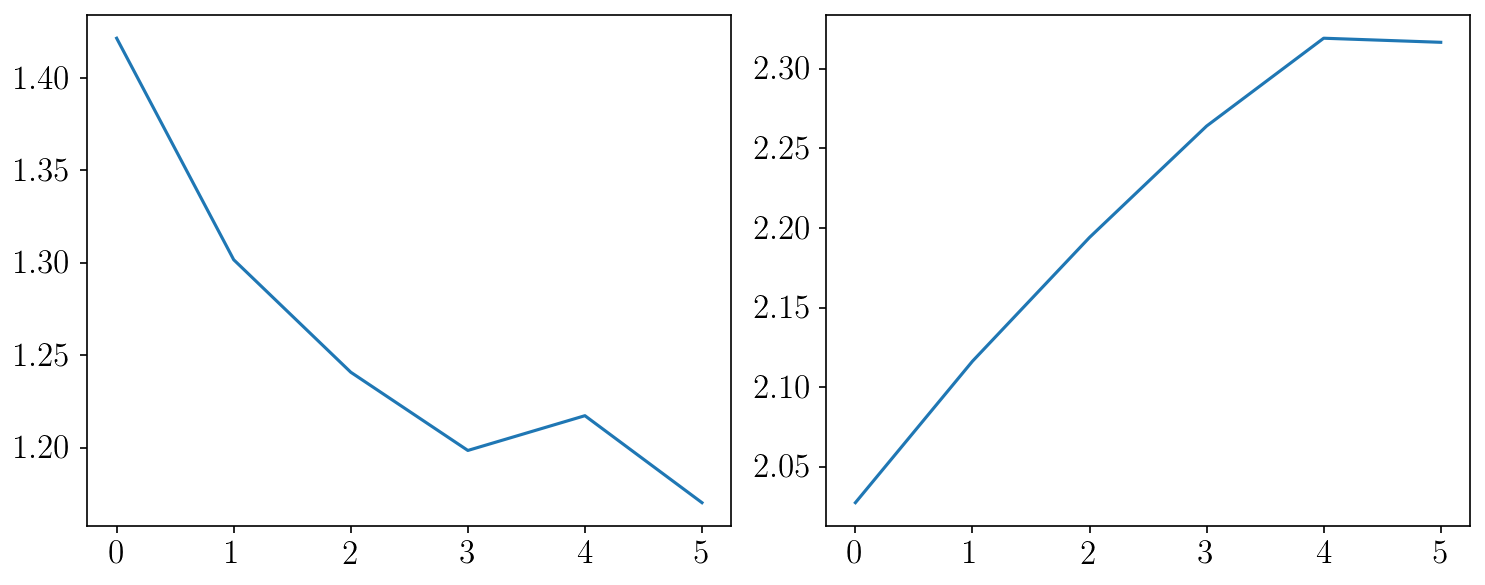

In [27]:
fig = plt.figure(figsize=(10, 4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(121) 
plt.plot(u_std_filt[0,list_sel_m2])
# plt.ylim(0,1.2)
# plt.plot(u_star_ldtr)
ax2 = fig.add_subplot(122) 
plt.plot(u_std_ldtr[0,list_sel_m2])
# plt.ylim(0,1.2)

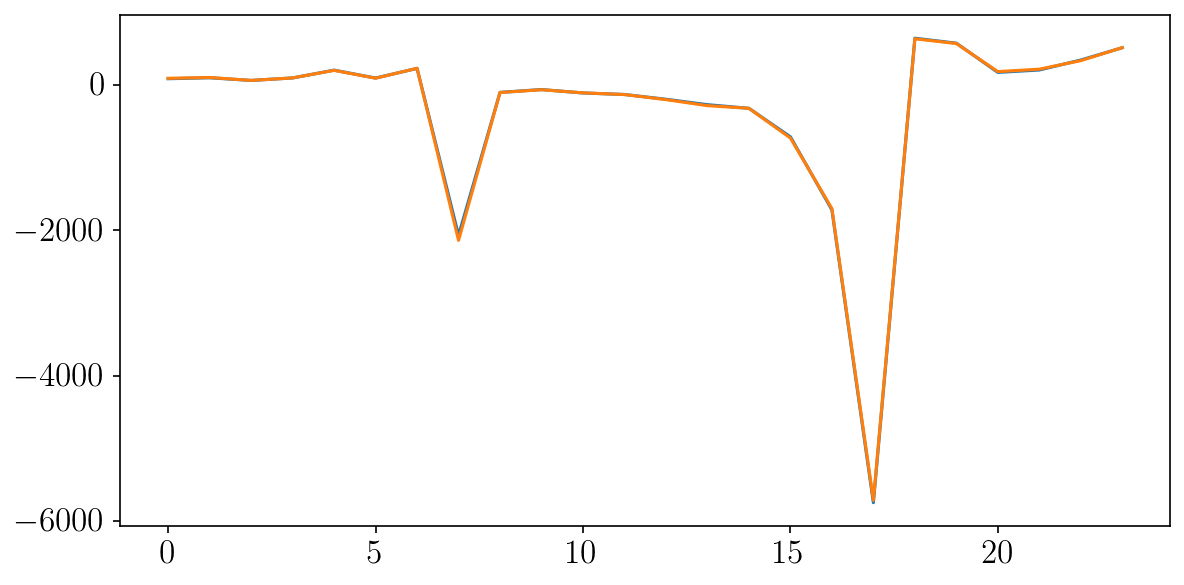

In [14]:
fig = plt.figure(figsize=(8, 4), dpi=150,tight_layout=True)
plt.plot(L_H2_filt[:,1])
plt.plot(L_H2_ldtr[:,1])

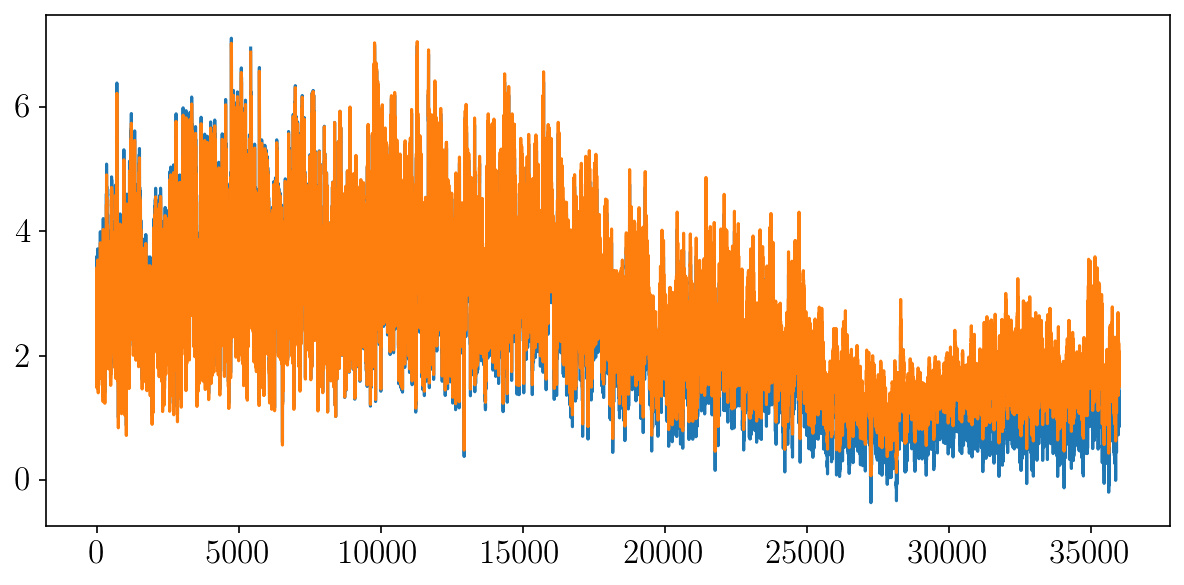

In [26]:
fig = plt.figure(figsize=(8, 4), dpi=150,tight_layout=True)
# plt.plot(u_2rot_dspk_filt[:,0])
plt.plot(u_dspk_2rot_ldtr[:,0])
plt.plot(u_dspk_2rot_filt[:,0])

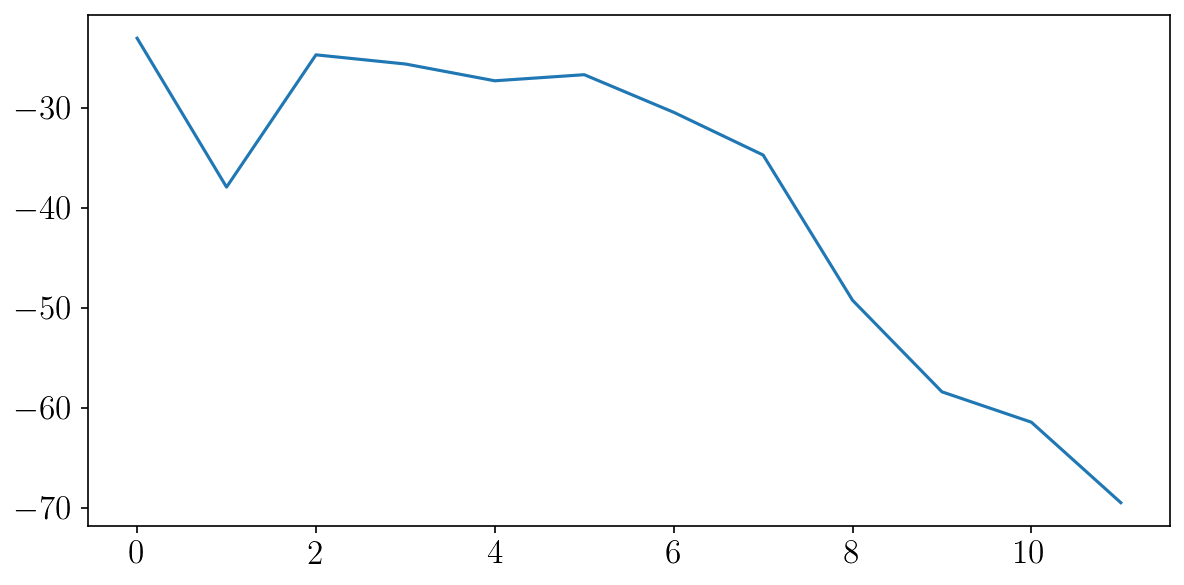

In [30]:
fig = plt.figure(figsize=(8, 4), dpi=150,tight_layout=True)
plt.plot(H_ldtr[0,:])
